## Daily usage

The daily_dataset folder contains measurements by day. We are certainly interested in:
* Daily/weekly/monthly/annual usage
* Usage by customer segment


In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import sys
import glob

data_dir = "/kaggle/input/smart-meters-in-london/daily_dataset/"

There are 112 files in this folder, with each file containing data for 50 homes

In [54]:
print(len(os.listdir(data_dir+'daily_dataset')))
os.listdir(data_dir+'daily_dataset')[:5]

112


['block_31.csv',
 'block_83.csv',
 'block_42.csv',
 'block_104.csv',
 'block_33.csv']

Read data for a single home

In [55]:
daily_df = pd.read_csv(data_dir+'daily_dataset/block_71.csv')
daily_df['day'] = pd.to_datetime(daily_df['day'])
daily_df = daily_df.set_index('day')
daily_df.head()

,LCLid,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
day,,,,,,,,
2011-12-07,MAC000027,0.1470,0.159880,0.408,25,0.062123,3.997,0.103
2011-12-08,MAC000027,0.1705,0.193479,0.459,48,0.077042,9.287,0.105
2011-12-09,MAC000027,0.1440,0.156771,0.365,48,0.051995,7.525,0.101
2011-12-10,MAC000027,0.2415,0.264250,0.814,48,0.135007,12.684,0.101
2011-12-11,MAC000027,0.2785,0.288438,0.540,48,0.112697,13.845,0.126


Each home is referenced by LCLid

In [56]:
len(daily_df["LCLid"].unique())

50

Plot usage for a single home, noting the data mostly covers 2012-2014

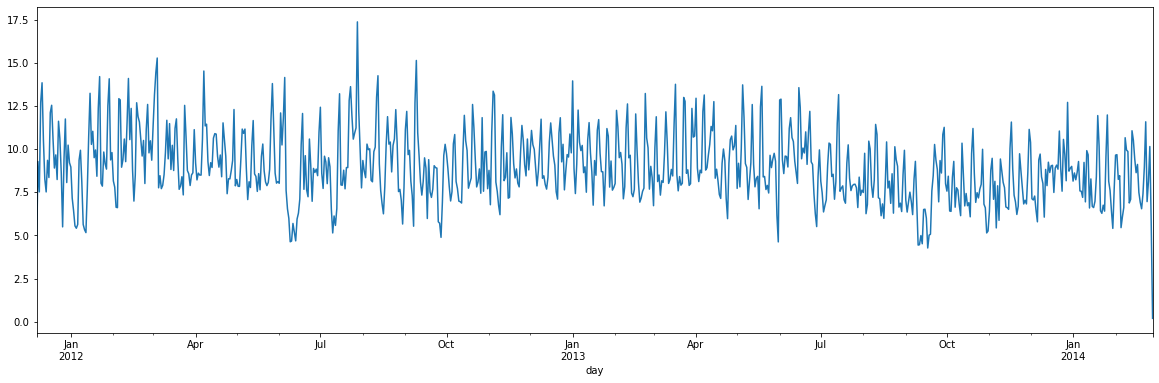

In [57]:
daily_df[daily_df["LCLid"]=="MAC000027"]["energy_sum"].plot(figsize=(20,6));

What we discover is that there is not data for all homes for all time, but it appears more homes are coming online during 2012

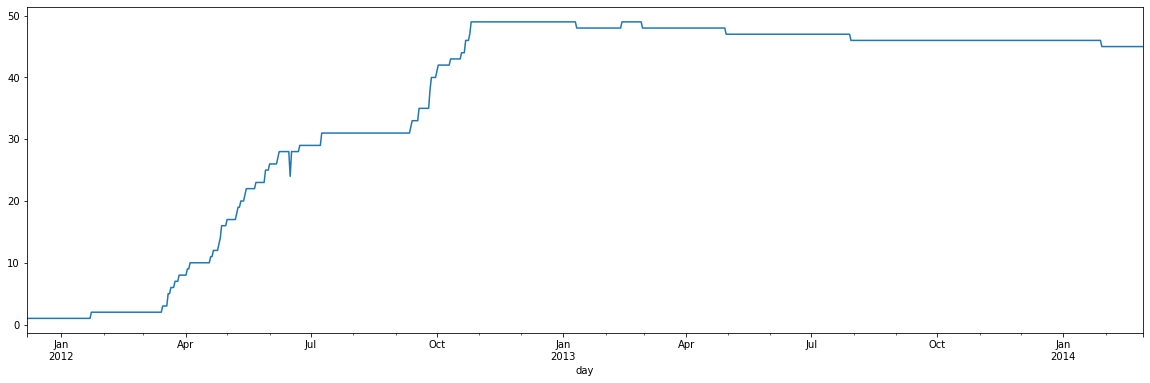

In [58]:
daily_df.reset_index().groupby("day").nunique()["LCLid"].plot(figsize=(20,6));

In order to account for the variation in number of measurements per day we could take an idea from another notebook here (todo add ref) and plot a normalised measure of energy use, energy use per household

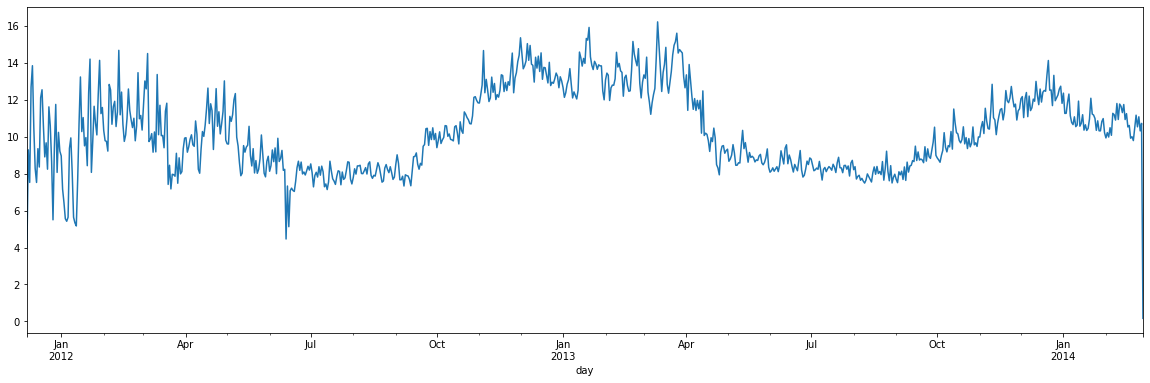

In [59]:

num_households_df = daily_df.reset_index().groupby("day").nunique()["LCLid"] # get the number of households on each day
energy_df = daily_df.reset_index().groupby("day").sum()["energy_sum"] # get the total energy usage per day

# normalise the energy usage to the number of households and plot
energy_per_household_df = pd.concat([num_households_df, energy_df], axis=1)
energy_per_household_df["normalised"] = energy_per_household_df["energy_sum"] / energy_per_household_df["LCLid"]
energy_per_household_df["normalised"].plot(figsize=(20,6));

Trend of increased energy usage over winter months. Note the curve is more noisy in early 2012 as there are fewer homes contributing measurements.

We can get the household grouping (Acorn_grouped) from the info file, and later we will merge this with the daily energy data.

In [60]:
info_df = pd.read_csv('/kaggle/input/smart-meters-in-london/informations_households.csv')
info_df.head()

,LCLid,stdorToU,Acorn,Acorn_grouped,file
0,MAC005492,ToU,ACORN-,ACORN-,block_0
1,MAC001074,ToU,ACORN-,ACORN-,block_0
2,MAC000002,Std,ACORN-A,Affluent,block_0
3,MAC003613,Std,ACORN-A,Affluent,block_0
4,MAC003597,Std,ACORN-A,Affluent,block_0



## Get all data from 112 files

Merge data from all files to single df


In [61]:
# Helper to load a single file
def daily_to_df(file_path : str) -> pd.DataFrame:
    df = pd.read_csv(file_path)
    df['day'] = pd.to_datetime(df['day'])
    df["year"] = df["day"].apply(lambda x : x.year)
    df["month"] = df["day"].apply(lambda x : x.month)
    df["dayofweek"] = df["day"].apply(lambda x : x.dayofweek)
    df["day_name"] = df["day"].apply(lambda x : x.day_name())
    df = df.merge(info_df, on="LCLid")
    df = df[df["year"].isin([2012, 2013])]
    return df[["LCLid", "day", "year", "month", "day_name", "Acorn_grouped", "energy_sum"]]

df = daily_to_df(data_dir+'daily_dataset/block_71.csv')
df.head()

,LCLid,day,year,month,day_name,Acorn_grouped,energy_sum
25,MAC000027,2012-01-01,2012,1,Sunday,Comfortable,8.962
26,MAC000027,2012-01-02,2012,1,Monday,Comfortable,7.159
27,MAC000027,2012-01-03,2012,1,Tuesday,Comfortable,6.430
28,MAC000027,2012-01-04,2012,1,Wednesday,Comfortable,5.556
29,MAC000027,2012-01-05,2012,1,Thursday,Comfortable,5.420


Loop over all 122 files and place in single dataframe. Note that we are just keeping data for 2012 & 2013 as these are mostly complete

In [62]:
all_daily_df = pd.DataFrame()

for i, file_path in enumerate(glob.glob(data_dir+'daily_dataset/*.csv')):
    all_daily_df = all_daily_df.append(daily_to_df(file_path))
    print(all_daily_df.shape)

(29703, 7)
(56886, 7)
(86421, 7)
(116444, 7)
(146579, 7)
(177226, 7)
(205666, 7)
(232870, 7)
(260391, 7)
(291176, 7)
(322111, 7)
(351446, 7)
(378349, 7)
(408742, 7)
(437884, 7)
(464492, 7)
(493686, 7)
(523950, 7)
(548493, 7)
(557472, 7)
(584889, 7)
(610843, 7)
(637928, 7)
(667637, 7)
(693000, 7)
(722273, 7)
(751286, 7)
(781653, 7)
(811410, 7)
(842474, 7)
(872524, 7)
(900166, 7)
(931091, 7)
(961386, 7)
(990800, 7)
(1020608, 7)
(1053922, 7)
(1085367, 7)
(1114757, 7)
(1144722, 7)
(1174814, 7)
(1205362, 7)
(1231951, 7)
(1259070, 7)
(1287172, 7)
(1313889, 7)
(1345131, 7)
(1372345, 7)
(1400877, 7)
(1430022, 7)
(1457128, 7)
(1487816, 7)
(1514094, 7)
(1540957, 7)
(1573209, 7)
(1602945, 7)
(1631874, 7)
(1660382, 7)
(1686897, 7)
(1718000, 7)
(1747076, 7)
(1777387, 7)
(1807140, 7)
(1836077, 7)
(1864209, 7)
(1893401, 7)
(1921913, 7)
(1950664, 7)
(1977540, 7)
(2004691, 7)
(2035077, 7)
(2060810, 7)
(2093016, 7)
(2119700, 7)
(2147999, 7)
(2176681, 7)
(2205422, 7)
(2234636, 7)
(2262206, 7)
(2290231, 7

Do some basic prep

In [63]:
all_daily_df = all_daily_df.drop_duplicates()
all_daily_df = all_daily_df.dropna()
all_daily_df.head()

,LCLid,day,year,month,day_name,Acorn_grouped,energy_sum
25,MAC000018,2012-01-01,2012,1,Sunday,Affluent,7.875
26,MAC000018,2012-01-02,2012,1,Monday,Affluent,11.055
27,MAC000018,2012-01-03,2012,1,Tuesday,Affluent,10.776
28,MAC000018,2012-01-04,2012,1,Wednesday,Affluent,15.515
29,MAC000018,2012-01-05,2012,1,Thursday,Affluent,17.494


check that number of measurements is consistent over time, there are actually more in 2013 so we will use 2013 data in subsequent analysis

## 2013

In [64]:
y2013_df = all_daily_df[all_daily_df['year']==2013]

In [65]:
y2013_df.groupby("Acorn_grouped").count()["LCLid"]

Acorn_grouped
ACORN-            247
ACORN-U         16957
Adversity      633152
Affluent       758448
Comfortable    531420
Name: LCLid, dtype: int64

Drop the two smallest groupings

In [66]:
y2013_df = y2013_df[y2013_df["Acorn_grouped"].isin(["Adversity", "Affluent", "Comfortable"])]


## Investigate usage by group

To account for the variation in measurements over time we will just use 2013 data and we will normalise to the number of LCLid, using the normalisation approach described earlier


In [67]:
sum_y2013_df = pd.concat([y2013_df.groupby("Acorn_grouped").sum()["energy_sum"], y2013_df.groupby("Acorn_grouped").count()["LCLid"]], axis=1)
sum_y2013_df["normalised"] = sum_y2013_df["energy_sum"] / sum_y2013_df["LCLid"]
sum_y2013_df

,energy_sum,LCLid,normalised
Acorn_grouped,,,
Adversity,5.373101e+06,633152,8.486273
Affluent,8.709586e+06,758448,11.483432
Comfortable,5.332296e+06,531420,10.034052


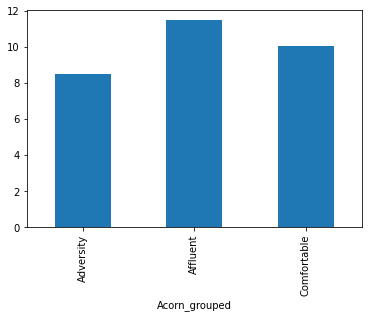

In [68]:
sum_y2013_df["normalised"].plot.bar();


Appears affluent use most energy whilst adversity the least, perhaps affluent have larger homes, more gadgets etc

## Usage by day

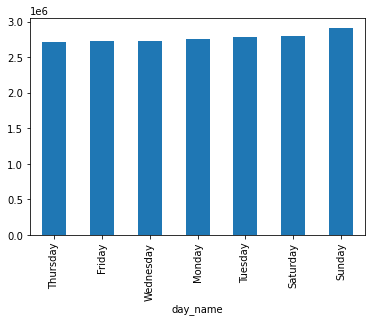

In [69]:
y2013_df.groupby("day_name").sum()["energy_sum"].sort_values().plot.bar();


Usage is slightly higher at weekends

## Usage by month (Seasonal Decomposition)

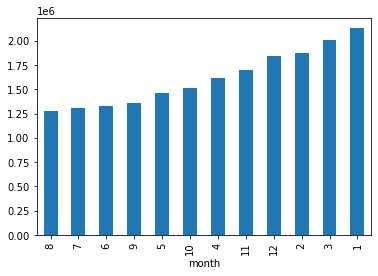

In [70]:
y2013_df.groupby("month").sum()["energy_sum"].sort_values().plot.bar()

usage is higher over winter.

## Summary
This notebook illustrates some basic EDA of the daily data and highlights the issue of varying number of data points over time, and uses normalisation to address this. The analysis shows that affluent households consume more energy, which aligns with our intuition. Analysis of daily and seasonal trends also tallies with common sense, showing higher consumption at weekends (when people are home) and over the winter.